# Homework 4 - Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

## Data Loading and Preparation

Load the Bank Marketing dataset and prepare it for classification.

Target variable: `converted` - has the client signed up to the platform or not.

In [2]:
# Load the dataset
df = pd.read_csv('course_lead_scoring.csv')

# Check the shape and first few rows
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (1462, 9)

First few rows:


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

Missing values per column:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

Total missing values: 606


In [4]:
# Check data types
print("Data types:")
print(df.dtypes)
print(f"\nCategorical columns: {list(df.select_dtypes(include='object').columns)}")
print(f"Numerical columns: {list(df.select_dtypes(include=[np.number]).columns)}")

Data types:
lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

Categorical columns: ['lead_source', 'industry', 'employment_status', 'location']
Numerical columns: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score', 'converted']


In [5]:
# Handle missing values
# For categorical features: replace with 'NA'
# For numerical features: replace with 0.0

categorical_columns = list(df.select_dtypes(include='object').columns)
numerical_columns = list(df.select_dtypes(include=[np.number]).columns)

# Remove target from numerical columns if present
if 'converted' in numerical_columns:
    numerical_columns.remove('converted')

# Fill missing values
for col in categorical_columns:
    df[col] = df[col].fillna('NA')

for col in numerical_columns:
    df[col] = df[col].fillna(0.0)

print("Missing values after handling:")
print(df.isnull().sum().sum())

Missing values after handling:
0


In [6]:
# Normalize column names and categorical values
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.select_dtypes(include='object').columns)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

print("Columns after normalization:")
print(df.columns.tolist())

Columns after normalization:
['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score', 'converted']


## Data Splitting

Split the data into train/validation/test with 60%/20%/20% distribution using `random_state=1`

In [7]:
# Split data: 60% train, 20% val, 20% test with seed 1
# First split: 60% train, 40% temp (val + test)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Second split: split the remaining 80% into 75/25 (60% train, 20% val of total)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

print(f"Train size: {len(df_train)} ({len(df_train)/len(df)*100:.1f}%)")
print(f"Val size: {len(df_val)} ({len(df_val)/len(df)*100:.1f}%)")
print(f"Test size: {len(df_test)} ({len(df_test)/len(df)*100:.1f}%)")
print(f"Full train size: {len(df_full_train)} ({len(df_full_train)/len(df)*100:.1f}%)")

# Extract target variable y
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values
y_full_train = df_full_train.converted.values

# Remove target variable from dataframes
del df_train['converted']
del df_val['converted']
del df_test['converted']
del df_full_train['converted']

print(f"\nTarget distribution:")
print(f"Train: {y_train.sum()} converted out of {len(y_train)} ({y_train.mean()*100:.1f}%)")
print(f"Val: {y_val.sum()} converted out of {len(y_val)} ({y_val.mean()*100:.1f}%)")
print(f"Test: {y_test.sum()} converted out of {len(y_test)} ({y_test.mean()*100:.1f}%)")
print(f"Full train: {y_full_train.sum()} converted out of {len(y_full_train)} ({y_full_train.mean()*100:.1f}%)")

Train size: 876 (59.9%)
Val size: 293 (20.0%)
Test size: 293 (20.0%)
Full train size: 1169 (80.0%)

Target distribution:
Train: 544 converted out of 876 (62.1%)
Val: 171 converted out of 293 (58.4%)
Test: 190 converted out of 293 (64.8%)
Full train: 715 converted out of 1169 (61.2%)


## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.

If your AUC is < 0.5, invert this variable by putting "-" in front.

Which numerical variable (among the following 4) has the highest AUC?
- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [8]:
# Define the numerical variables to evaluate
numerical_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

# Calculate AUC for each numerical variable
auc_scores = {}

for var in numerical_vars:
    # Use the variable as prediction score
    score = df_train[var].values
    
    # Calculate AUC
    auc = roc_auc_score(y_train, score)
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -score)
        print(f"{var}: {auc:.6f} (inverted)")
    else:
        print(f"{var}: {auc:.6f}")
    
    auc_scores[var] = auc

# Find the variable with highest AUC
best_var = max(auc_scores, key=auc_scores.get)
print(f"\nVariable with highest AUC: {best_var} ({auc_scores[best_var]:.6f})")

lead_score: 0.614499
number_of_courses_viewed: 0.763568
interaction_count: 0.738270
annual_income: 0.551958

Variable with highest AUC: number_of_courses_viewed (0.763568)


## Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [9]:
# Define features
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
categorical = [col for col in df_train.columns if col not in numerical]

print(f"Numerical features: {numerical}")
print(f"Categorical features: {categorical}")

Numerical features: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
Categorical features: ['lead_source', 'industry', 'employment_status', 'location']


In [10]:
# One-hot encoding using DictVectorizer
dv = DictVectorizer(sparse=False)

# Prepare training data
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

# Train logistic regression model with specified parameters
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Prepare validation data
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

# Calculate AUC on validation set
y_pred_proba = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_proba)

print(f"Validation AUC: {auc}")
print(f"Validation AUC (rounded to 3 digits): {round(auc, 3)}")

round(auc, 3)

Validation AUC: 0.8171316268814112
Validation AUC (rounded to 3 digits): 0.817


0.817

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

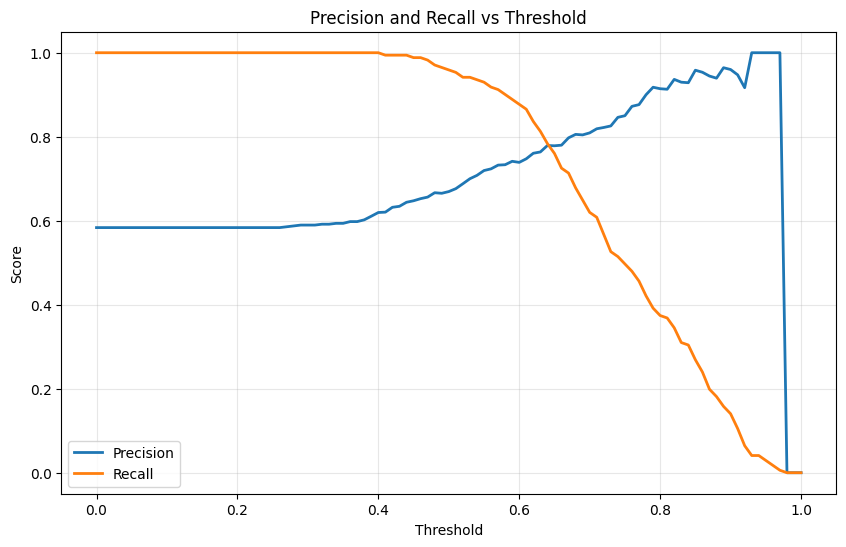


Precision and recall intersect at threshold: 0.980
Precision at intersection: 0.000
Recall at intersection: 0.000


In [11]:
# Compute precision and recall for different thresholds
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for threshold in thresholds:
    # Apply threshold to get predictions
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate precision and recall
    # Handle edge cases where there are no positive predictions
    if y_pred.sum() == 0:
        precision = 0
    else:
        precision = precision_score(y_val, y_pred, zero_division=0)
    
    recall = recall_score(y_val, y_pred, zero_division=0)
    
    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find intersection point
# Find where the difference is smallest
differences = np.abs(np.array(precisions) - np.array(recalls))
intersection_idx = np.argmin(differences)
intersection_threshold = thresholds[intersection_idx]

print(f"\nPrecision and recall intersect at threshold: {intersection_threshold:.3f}")
print(f"Precision at intersection: {precisions[intersection_idx]:.3f}")
print(f"Recall at intersection: {recalls[intersection_idx]:.3f}")

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both.

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

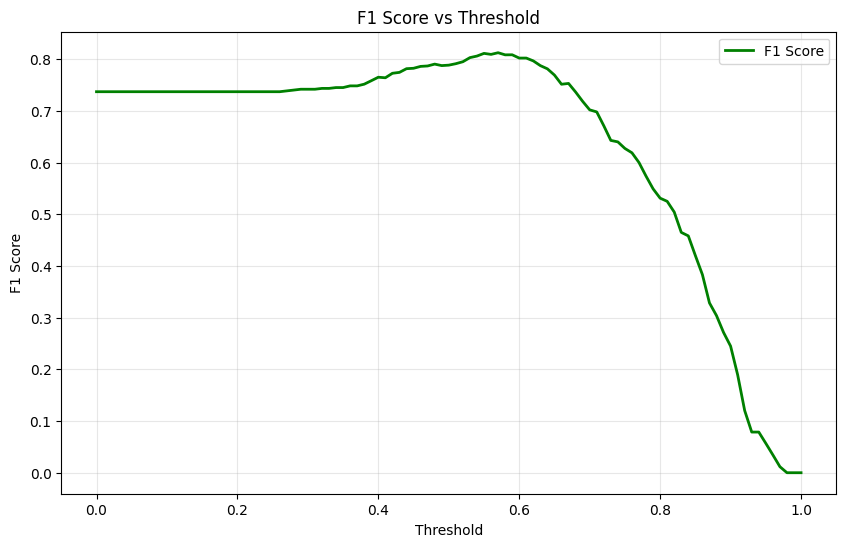


Maximum F1 score: 0.812
Threshold at maximum F1: 0.57


In [12]:
# Compute F1 scores for different thresholds
f1_scores = []

for threshold in thresholds:
    # Apply threshold to get predictions
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate F1 score
    f1 = f1_score(y_val, y_pred, zero_division=0)
    f1_scores.append(f1)

# Plot F1 score curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2, color='green')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find threshold with maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

print(f"\nMaximum F1 score: {max_f1_score:.3f}")
print(f"Threshold at maximum F1: {max_f1_threshold:.2f}")

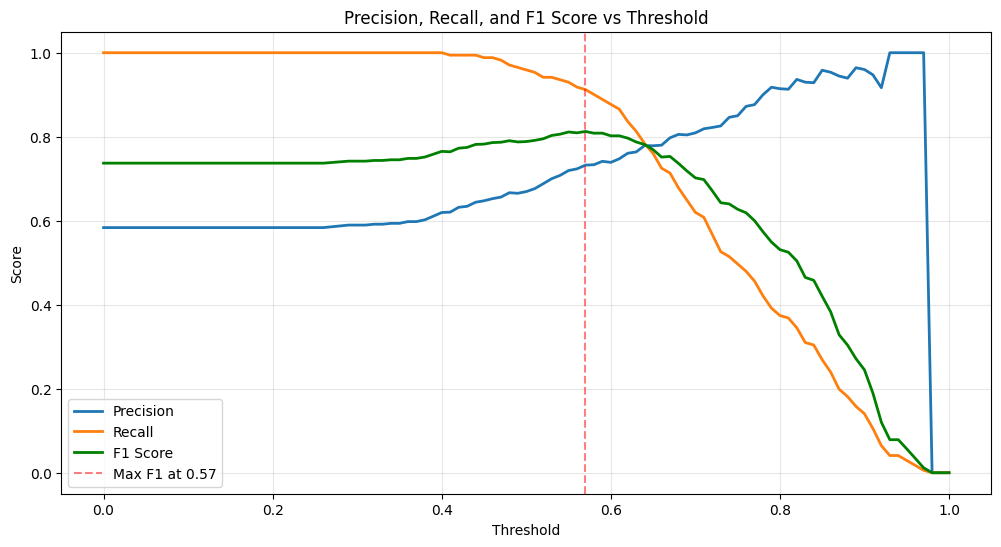

In [13]:
# Plot all three metrics together
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2, color='green')
plt.axvline(x=max_f1_threshold, color='red', linestyle='--', alpha=0.5, label=f'Max F1 at {max_f1_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Question 5: 5-Fold CV

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```python
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

In [14]:
# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Store AUC scores for each fold
auc_scores_cv = []

# Iterate over folds
for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train), 1):
    # Split data
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]
    
    y_train_fold = y_full_train[train_idx]
    y_val_fold = y_full_train[val_idx]
    
    # Prepare data with DictVectorizer
    dv = DictVectorizer(sparse=False)
    
    train_dict = df_train_fold[categorical + numerical].to_dict(orient='records')
    X_train_fold = dv.fit_transform(train_dict)
    
    val_dict = df_val_fold[categorical + numerical].to_dict(orient='records')
    X_val_fold = dv.transform(val_dict)
    
    # Train model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    
    # Predict and calculate AUC
    y_pred_proba_fold = model.predict_proba(X_val_fold)[:, 1]
    auc_fold = roc_auc_score(y_val_fold, y_pred_proba_fold)
    
    auc_scores_cv.append(auc_fold)
    print(f"Fold {fold}: AUC = {auc_fold:.6f}")

# Calculate mean and standard deviation
mean_auc = np.mean(auc_scores_cv)
std_auc = np.std(auc_scores_cv)

print(f"\n{'='*50}")
print(f"Mean AUC: {mean_auc:.6f}")
print(f"Standard deviation: {std_auc:.6f}")
print(f"Standard deviation (rounded to 3 digits): {round(std_auc, 3)}")

Fold 1: AUC = 0.806075
Fold 2: AUC = 0.871374
Fold 3: AUC = 0.775432
Fold 4: AUC = 0.801837
Fold 5: AUC = 0.855827

Mean AUC: 0.822109
Standard deviation: 0.035807
Standard deviation (rounded to 3 digits): 0.036


## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [15]:
# C values to test
C_values = [0.000001, 0.001, 1]

# Store results
results = {}

print("Testing different C values with 5-Fold CV:")
print("="*60)

for C in C_values:
    print(f"\nC = {C}")
    
    # Initialize KFold
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    # Store AUC scores for each fold
    auc_scores_c = []
    
    # Iterate over folds
    for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train), 1):
        # Split data
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]
        
        y_train_fold = y_full_train[train_idx]
        y_val_fold = y_full_train[val_idx]
        
        # Prepare data with DictVectorizer
        dv = DictVectorizer(sparse=False)
        
        train_dict = df_train_fold[categorical + numerical].to_dict(orient='records')
        X_train_fold = dv.fit_transform(train_dict)
        
        val_dict = df_val_fold[categorical + numerical].to_dict(orient='records')
        X_val_fold = dv.transform(val_dict)
        
        # Train model with current C
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)
        
        # Predict and calculate AUC
        y_pred_proba_fold = model.predict_proba(X_val_fold)[:, 1]
        auc_fold = roc_auc_score(y_val_fold, y_pred_proba_fold)
        
        auc_scores_c.append(auc_fold)
        print(f"  Fold {fold}: AUC = {auc_fold:.6f}")
    
    # Calculate mean and std
    mean_auc_c = np.mean(auc_scores_c)
    std_auc_c = np.std(auc_scores_c)
    
    # Round to 3 decimal digits
    mean_auc_c_rounded = round(mean_auc_c, 3)
    std_auc_c_rounded = round(std_auc_c, 3)
    
    results[C] = {
        'mean': mean_auc_c_rounded,
        'std': std_auc_c_rounded,
        'scores': auc_scores_c
    }
    
    print(f"  Mean AUC: {mean_auc_c_rounded}")
    print(f"  Std AUC: {std_auc_c_rounded}")

print(f"\n{'='*60}")
print("\nSummary:")
for C in C_values:
    print(f"C = {C:>10}: mean = {results[C]['mean']:.3f}, std = {results[C]['std']:.3f}")

Testing different C values with 5-Fold CV:

C = 1e-06
  Fold 1: AUC = 0.557210
  Fold 2: AUC = 0.519196
  Fold 3: AUC = 0.589491
  Fold 4: AUC = 0.558219
  Fold 5: AUC = 0.576923
  Mean AUC: 0.56
  Std AUC: 0.024

C = 0.001
  Fold 1: AUC = 0.860865
  Fold 2: AUC = 0.896708
  Fold 3: AUC = 0.822816
  Fold 4: AUC = 0.853985
  Fold 5: AUC = 0.900015
  Mean AUC: 0.867
  Std AUC: 0.029

C = 1
  Fold 1: AUC = 0.806075
  Fold 2: AUC = 0.871374
  Fold 3: AUC = 0.775432
  Fold 4: AUC = 0.801837
  Fold 5: AUC = 0.855827
  Mean AUC: 0.822
  Std AUC: 0.036


Summary:
C =      1e-06: mean = 0.560, std = 0.024
C =      0.001: mean = 0.867, std = 0.029
C =          1: mean = 0.822, std = 0.036


In [16]:
# Find the best C
# Rule: highest mean, then lowest std, then smallest C

# Sort by mean (descending), then std (ascending), then C (ascending)
sorted_results = sorted(results.items(), 
                       key=lambda x: (-x[1]['mean'], x[1]['std'], x[0]))

best_C = sorted_results[0][0]
best_mean = sorted_results[0][1]['mean']
best_std = sorted_results[0][1]['std']

print(f"Best C: {best_C}")
print(f"Mean AUC: {best_mean}")
print(f"Std AUC: {best_std}")

Best C: 0.001
Mean AUC: 0.867
Std AUC: 0.029
